In [1]:
#Installing the required package

!pip install split-folders

In [2]:
!pip install onnx-tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 5.5 MB/s eta 0:00:00


In [3]:
!pip install onnx

In [4]:
import numpy as np
import pandas as pd 
import os
import cv2
import random
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import keras
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import splitfolders

In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from pathlib import Path

from collections import Counter

from PIL import Image

In [6]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torchmetrics

In [7]:
ds_path = Path('../input/flowers/flowers').resolve()

paths = list(ds_path.glob('*/*'))
classes = [path.parent.stem for path in paths]

Counter(classes), len(classes), len(set(classes))

(Counter({'astilbe': 737,
          'daffodil': 970,
          'black_eyed_susan': 1000,
          'bellflower': 873,
          'common_daisy': 980,
          'coreopsis': 1047,
          'dandelion': 1052,
          'water_lily': 982,
          'carnation': 923,
          'calendula': 978,
          'california_poppy': 1022,
          'sunflower': 1027,
          'tulip': 1048,
          'rose': 999,
          'magnolia': 1048,
          'iris': 1054}),
 15740,
 16)

In [8]:
df = pd.DataFrame({'path': paths, 'class': classes})
df['class'] = df['class'].astype('category')
df['label'] = df['class'].cat.codes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15740 entries, 0 to 15739
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   path    15740 non-null  object  
 1   class   15740 non-null  category
 2   label   15740 non-null  int8    
dtypes: category(1), int8(1), object(1)
memory usage: 154.5+ KB


In [9]:
class_labels = dict(zip(range(16), df['class'].cat.categories))
class_labels

{0: 'astilbe',
 1: 'bellflower',
 2: 'black_eyed_susan',
 3: 'calendula',
 4: 'california_poppy',
 5: 'carnation',
 6: 'common_daisy',
 7: 'coreopsis',
 8: 'daffodil',
 9: 'dandelion',
 10: 'iris',
 11: 'magnolia',
 12: 'rose',
 13: 'sunflower',
 14: 'tulip',
 15: 'water_lily'}

In [10]:
df.tail(10)

,path,class,label
15730,/kaggle/input/flowers/flowers/iris/7183449485_...,iris,10
15731,/kaggle/input/flowers/flowers/iris/8753156569_...,iris,10
15732,/kaggle/input/flowers/flowers/iris/34813147012...,iris,10
15733,/kaggle/input/flowers/flowers/iris/17745911753...,iris,10
15734,/kaggle/input/flowers/flowers/iris/13993696698...,iris,10
15735,/kaggle/input/flowers/flowers/iris/40502574023...,iris,10
15736,/kaggle/input/flowers/flowers/iris/3516534783_...,iris,10
15737,/kaggle/input/flowers/flowers/iris/4614530689_...,iris,10
15738,/kaggle/input/flowers/flowers/iris/3685522287_...,iris,10
15739,/kaggle/input/flowers/flowers/iris/3572644076_...,iris,10


In [11]:
from sklearn.model_selection import train_test_split

# Split
* The dataset will be split into train and test data
* Train dataset will further be split with StratifiedKFolds into train and val datasets

In [12]:
train, test = train_test_split(df, test_size=0.1, shuffle=True, random_state=1230, stratify=df['label'])
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
len(train), len(test)

(14166, 1574)

# Custom Dataset

In [13]:
class Flowers:
    def __init__(self, df, augmentations=None):
        self.paths = df['path'].values
        self.labels = df['label'].values
        
        if augmentations is None:
            self.augmentations = transform = transforms.Compose([
                                    transforms.RandomRotation(degrees=0.5),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                    transforms.RandomAffine(degrees=0.2),
                                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                                    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.2)),
                                    transforms.RandomApply([transforms.RandomCrop(size=(224, 224), padding=20)], p=0.3),
                                    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.2),
                                    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=0.2),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])
        else:
            self.augmentations = augmentations
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        sample = self.paths[idx]
        
        sample = Image.open(sample).convert(mode='RGB')
        sample = self.augmentations(sample)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return (sample, label)

In [14]:
test_ds = Flowers(test)

In [15]:
len(test_ds)

1574

In [16]:
pic_from_each = test.groupby('class').apply(lambda s: s.sample(1)).reset_index(drop=True)
pic_from_each['class'].value_counts()

astilbe             1
bellflower          1
black_eyed_susan    1
calendula           1
california_poppy    1
carnation           1
common_daisy        1
coreopsis           1
daffodil            1
dandelion           1
iris                1
magnolia            1
rose                1
sunflower           1
tulip               1
water_lily          1
Name: class, dtype: int64

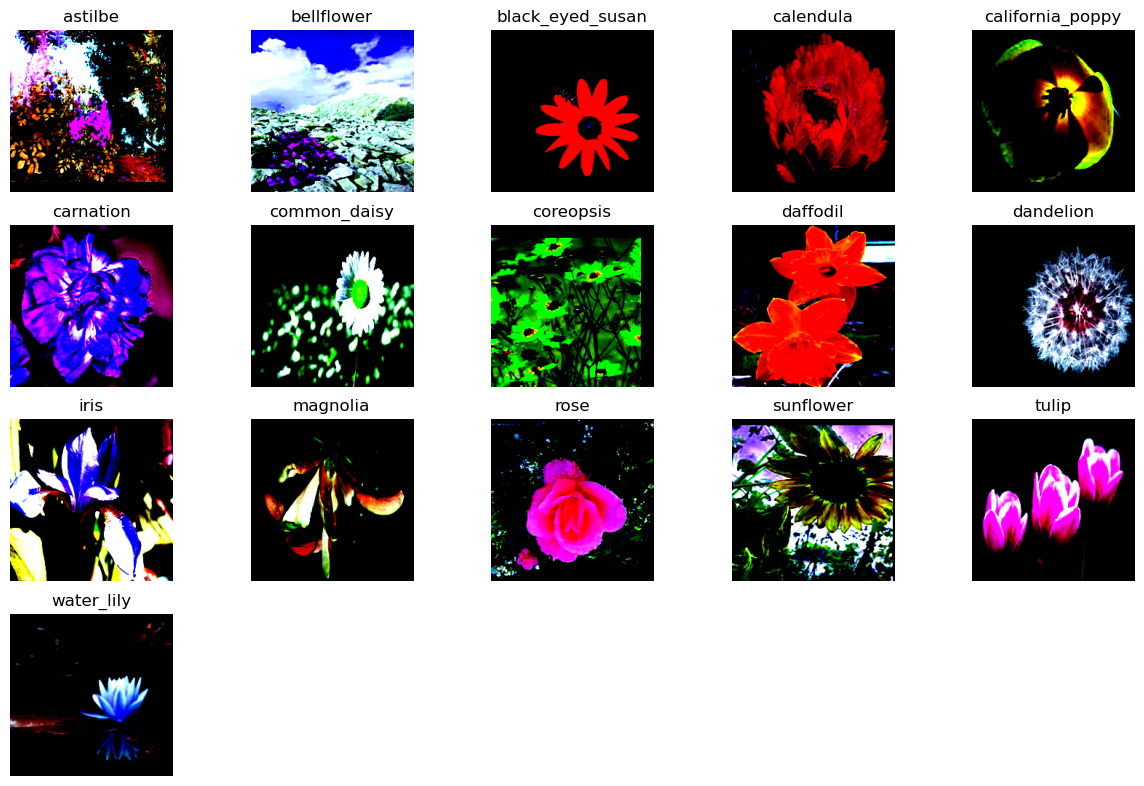

In [17]:
pic_from_each_ds = Flowers(pic_from_each)

figure = plt.figure(figsize=(15,40))
for i in range(1,len(pic_from_each_ds)+1):
    img = pic_from_each_ds[i-1][0].permute(1,2,0)
    label = class_labels[pic_from_each_ds[i-1][1].item()]
    figure.add_subplot(16,5,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

In [18]:
import torchmetrics

class ResNet50Model(pl.LightningModule):
    
    def __init__(self, pretrained=True, in_channels = 3, num_classes = 16, lr=3e-4, freeze=False):
        super(ResNet50Model, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.lr = lr
        
        self.model = models.resnet50(pretrained=pretrained)
        
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False
        
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 128),
            nn.Dropout(0.3),
            nn.Linear(128, self.num_classes)
        )
        
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=self.num_classes)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=self.num_classes)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=self.num_classes)
  
        
        
        
    def forward(self, x):
        return self.model(x)
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2)
        return [optimizer], [scheduler]
    
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        
        preds = self.model(x)
        
        loss = self.loss_fn(preds, y)
        self.train_acc(torch.argmax(preds, dim=1), y)
        
        self.log('train_loss', loss.item(), on_epoch=True)
        self.log('train_acc', self.train_acc, on_epoch=True)
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        
        x,y = batch
        
        preds = self.model(x)
        
        loss = self.loss_fn(preds, y)
        self.val_acc(torch.argmax(preds, dim=1), y)
        
        self.log('val_loss', loss.item(), on_epoch=True)
        self.log('val_acc', self.val_acc, on_epoch=True)
        
    
    def test_step(self, batch, batch_idx):
        
        x,y = batch
        preds = self.model(x)
        self.test_acc(torch.argmax(preds, dim=1), y)
        
        self.log('test_acc', self.test_acc, on_epoch=True)

In [19]:
m = ResNet50Model()
m.model

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Train Data Agumentations

In [20]:
train_augmentations = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomEqualize(0.2),
    transforms.RandomPosterize(8,p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet Mean
                         std=[0.229, 0.224, 0.225]   # ImageNet Std
                        ),
    transforms.RandomResizedCrop(180),
])
val_augmentations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet Mean
                         std=[0.229, 0.224, 0.225]   # ImageNet Std
                        ),
    transforms.RandomResizedCrop(180),
])

In [21]:
from sklearn.model_selection import StratifiedKFold

num_folds = 4
kf = StratifiedKFold(num_folds)


lr = 3e-4

logs = dict()

for fold, (train_fold, val_fold) in enumerate(kf.split(X=train, y=train['label']), start=1):
    
    train_df = train.loc[train_fold]
    val_df = train.loc[val_fold]
    
    train_ds = Flowers(train_df, augmentations=train_augmentations)
    val_ds = Flowers(val_df, augmentations=val_augmentations)
    test_ds = Flowers(test, augmentations=val_augmentations)
    
    print(f"\nsamples:: train: {len(train_ds)} | valid: {len(val_ds)} | test: {len(test_ds)}\n")
    
    train_dataloader = torch.utils.data.DataLoader(train_ds,batch_size=64,num_workers=2)
    val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=64,num_workers=2)
    test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=128, num_workers=2)
    
    model = ResNet50Model()
    trainer = pl.Trainer(accelerator='gpu', 
                         max_epochs=10,
                         callbacks=[
                         EarlyStopping(monitor="val_loss", 
                                       mode="min",
                                       patience=2,
                                      )
                         ]
                        )
    
    model.hparams.lr = lr
    
    
    print(f"\n\n\n{'=='*20} FOLD {fold} / {num_folds} {'=='*20}")
    
    trainer.fit(model, train_dataloader, val_dataloader)
    metrics = trainer.logged_metrics
    trainer.test(model, test_dataloader)
    
    logs[f'fold{fold}'] = {
        'train_loss': metrics['train_loss_epoch'].item(),
        'val_loss': metrics['val_loss'].item(),
        'train_acc': metrics['train_acc_epoch'].item(),
        'val_acc': metrics['val_acc'].item()
    }
    
    print(f"Train Loss: {logs[f'fold{fold}']['train_loss']} | Train Accuracy: {logs[f'fold{fold}']['train_acc']}")
    print(f"Val Loss: {logs[f'fold{fold}']['val_loss']} | Val Accuracy: {logs[f'fold{fold}']['val_acc']}")


samples:: train: 10624 | valid: 3542 | test: 1574



/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)





======================================== FOLD 1 / 4 ========================================


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9269377589225769     │
└───────────────────────────┴───────────────────────────┘

Train Loss: 0.29386624693870544 | Train Accuracy: 0.9086031913757324
Val Loss: 0.24579206109046936 | Val Accuracy: 0.9192546606063843

samples:: train: 10624 | valid: 3542 | test: 1574




======================================== FOLD 2 / 4 ========================================


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9104192852973938     │
└───────────────────────────┴───────────────────────────┘

Train Loss: 0.2949146330356598 | Train Accuracy: 0.9065324068069458
Val Loss: 0.2500409185886383 | Val Accuracy: 0.926595151424408

samples:: train: 10625 | valid: 3541 | test: 1574




======================================== FOLD 3 / 4 ========================================


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9218551516532898     │
└───────────────────────────┴───────────────────────────┘

Train Loss: 0.2813846468925476 | Train Accuracy: 0.9151058793067932
Val Loss: 0.27451059222221375 | Val Accuracy: 0.9144309759140015

samples:: train: 10625 | valid: 3541 | test: 1574




======================================== FOLD 4 / 4 ========================================


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9224904775619507     │
└───────────────────────────┴───────────────────────────┘

Train Loss: 0.26813164353370667 | Train Accuracy: 0.9153882265090942
Val Loss: 0.27356478571891785 | Val Accuracy: 0.9195142388343811


In [22]:
fold_train_losses = [logs[f'fold{fold}']['train_loss'] for fold in range(1,num_folds+1)]
fold_valid_losses = [logs[f'fold{fold}']['val_loss'] for fold in range(1,num_folds+1)]
fold_train_accs = [logs[f'fold{fold}']['train_acc'] for fold in range(1,num_folds+1)]
fold_valid_accs = [logs[f'fold{fold}']['val_acc'] for fold in range(1,num_folds+1)]
logs_df = pd.DataFrame({
    'fold': list(range(1,num_folds+1)),
    'train loss': fold_train_losses,
    'validation loss': fold_valid_losses,
    'train accuracy': fold_train_accs,
    'validation accuracy': fold_valid_accs
})

In [23]:
logs_df

,fold,train loss,validation loss,train accuracy,validation accuracy
0,1,0.293866,0.245792,0.908603,0.919255
1,2,0.294915,0.250041,0.906532,0.926595
2,3,0.281385,0.274511,0.915106,0.914431
3,4,0.268132,0.273565,0.915388,0.919514


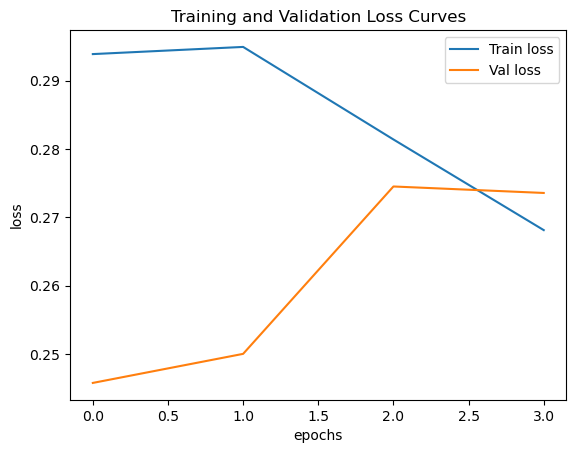

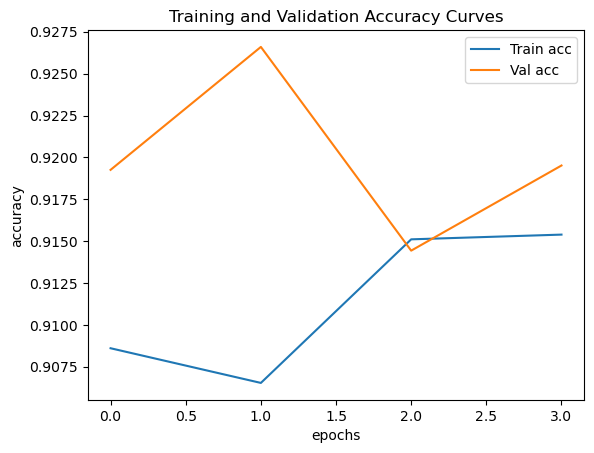

In [24]:
import matplotlib.pyplot as plt

# collect loss and accuracy values
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for fold in range(1, num_folds+1):
    train_losses.append(logs[f"fold{fold}"]["train_loss"])
    val_losses.append(logs[f"fold{fold}"]["val_loss"])
    train_accs.append(logs[f"fold{fold}"]["train_acc"])
    val_accs.append(logs[f"fold{fold}"]["val_acc"])

# plot loss curves
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

# plot accuracy curves
plt.plot(train_accs, label="Train acc")
plt.plot(val_accs, label="Val acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy Curves")
plt.legend()
plt.show()


In [25]:
if not os.path.exists('./models/'):
    os.mkdir('./models/')

torch.save(model.state_dict(), './models/flowers.pt')

In [26]:
model2 = ResNet50Model()
model2.load_state_dict(torch.load('./models/flowers.pt'))

# create an example input tensor
batch_size = 1
input_channels = 3
input_size = (224, 224)
example_input = torch.randn(batch_size, input_channels, *input_size)

# export the model to ONNX
output_path = "/kaggle/working/models/Flowers.onnx"
torch.onnx.export(model2, example_input, output_path, verbose=False, input_names=["input"], output_names=["output"])

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
from onnx_tf.backend import prepare
import onnx

model = onnx.load('/kaggle/working/models/Flowers.onnx')
tf_rep = prepare(model) 

In [28]:
# Export model as .pb file
tf_rep.export_graph('/kaggle/working/models/flowers.pb')

In [29]:
# path = "flowers.pb"

# if os.path.isdir(path):
#     print(f"{path} is a directory")
# elif os.path.isfile(path):
#     print(f"{path} is a file")
# else:
#     print(f"{path} is not a valid path")

In [30]:
# import shutil
# shutil.rmtree("/kaggle/working/models") 

In [31]:
# import tensorflow as tf

# def load_pb(path_to_pb):
#     with tf.io.gfile.GFile(os.path.join(path_to_pb, 'Flowers.pb'), 'rb') as f:
#         graph_def = tf.compat.v1.GraphDef()
#         graph_def.ParseFromString(f.read())
#     with tf.Graph().as_default() as graph:
#         tf.import_graph_def(graph_def, name='')
#         return graph

In [32]:
# tf_graph = load_pb('/kaggle/working/tfmodel/')
# sess = tf.compat.v1.Session(graph=tf_graph)

# # Show tensor names in graph
# for op in tf_graph.get_operations():
#     print(op.values())